# Deep learning Keras-based solution of the MNIST problem

## 1. Load data

In [1]:
# Todo add K-fold
# Todo choose the best params and cnn architecture
# Todo add a pipeline to scale params
# Todo implement augmentation?
# Todo try to get a pretrained cnn

In [2]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
log = logging.getLogger()

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path

import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv('../data/train.csv.zip')
args.raw_test = pd.read_csv('../data/test.csv.zip')
args.predictions_folder = Path('../predictions')
args.n_splits = 5
args.n_jobs = 3
args.val_fraction = 0.1
args.epochs = 200
args.model_name = 'model.hdf5'

args.X = args.raw_train.iloc[:, 1:].copy()
args.y = args.raw_train['label'].copy()
args.x = args.raw_test.copy()

args.run_baseline_cnn = False
args.run_kfold_cnn = False

args.predictions_folder.mkdir(parents=True, exist_ok=True) 

In [4]:
args.raw_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
args.raw_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
args.raw_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [7]:
def draw_number(label, pixels_2d, size_inches=None):
    title = args.raw_train.iloc[random_row, 0]
    fig, ax = plt.subplots()
    if size_inches:
        fig.set_size_inches(size_inches[0], size_inches[1])
    ax.set_title(label)
    imgplot = ax.imshow(pixels_2d)

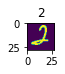

In [8]:
# Matlbab state-based style of image rendering 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1)
label = args.raw_train.iloc[random_row, 0]
pixels_2d = args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28)
draw_number(label, pixels_2d, (0.5, 0.5))

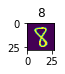

In [9]:
# OO-style image rendering
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1)
label = args.raw_train.iloc[random_row, 0]
pixels_2d = args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28)
draw_number(label, pixels_2d, (0.5, 0.5))

## 2. Training

In [10]:
X = args.X.to_numpy().reshape(args.X.shape[0], 28, 28, 1)
y = pd.get_dummies(args.y, prefix='label').to_numpy()
y1 = args.y.to_numpy()
x = args.x.to_numpy().reshape(args.x.shape[0], 28, 28, 1)

In [11]:
import sklearn.utils.multiclass

log.info('X.shape: %s', repr(X.shape))
log.info('X[0][14][14]: %s', X[0][14][14])

log.info('y.shape: %s', repr(y.shape))
log.info('y[0], %s', y[0])
log.info('type of target y: %s', repr(sklearn.utils.multiclass.type_of_target(y)))

log.info('y1.shape: %s', repr(y1.shape))
log.info('y1: %s', repr(y1))
log.info('y1[0]: %s', y1[0])
log.info('type of target y1: %s', repr(sklearn.utils.multiclass.type_of_target(y1)))

2020-04-10 18:33:57,547 : INFO : X.shape: (42000, 28, 28, 1)
2020-04-10 18:33:57,547 : INFO : X[0][14][14]: [254]
2020-04-10 18:33:57,548 : INFO : y.shape: (42000, 10)
2020-04-10 18:33:57,549 : INFO : y[0], [0 1 0 0 0 0 0 0 0 0]
2020-04-10 18:33:57,554 : INFO : type of target y: 'multilabel-indicator'
2020-04-10 18:33:57,554 : INFO : y1.shape: (42000,)
2020-04-10 18:33:57,555 : INFO : y1: array([1, 0, 1, ..., 7, 6, 9])
2020-04-10 18:33:57,556 : INFO : y1[0]: 1
2020-04-10 18:33:57,557 : INFO : type of target y1: 'multiclass'


In [12]:
def predict(X, y, x, build_classifier, parameters, splits=args.n_splits, n_jobs=args.n_jobs):
    skf = StratifiedKFold(n_splits=splits, shuffle=True)
    classifier = build_classifier()
    gcv = GridSearchCV(classifier, parameters, n_jobs=n_jobs, cv=skf, verbose=5)
    gcv.fit(X, y)
    log.info('Best params: %s', repr(gcv.best_params_))
    log.info('Best CV score: %s', repr(gcv.best_score_))
    log.info('Best std: %s', repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))
    classifier = build_classifier(gcv.best_params_)
    classifier.fit(X, y)
    predictions = classifier.predict(x)
    return gcv.best_params_, gcv.best_score_, predictions.astype(int)

In [13]:
def csv_predictions(predictions_sparse, filename):
    image_ids = np.arange(1, len(predictions) + 1)
    submission = pd.DataFrame({'ImageId': image_ids, 'Label': predictions_sparse})
    filepath = args.predictions_folder/filename
    
    submission.to_csv(filepath, index=False)
    log.info('Saved file: %s', filepath)

In [14]:
from keras import layers 
from keras import models

def build_baseline_model_sparse():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    log.info(model.summary())
    return model

Using TensorFlow backend.


### 2.1 Baseline

In [15]:
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# val_loss
# val_accuracy
early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=3, mode='auto', verbose=1)
model_checkpoint = ModelCheckpoint(args.model_name, save_best_only=True, monitor='val_sparse_categorical_accuracy', mode='auto', verbose=1)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='auto')

model = build_baseline_model_sparse()
model.fit(X, y1, validation_split=args.val_fraction, epochs=args.epochs, batch_size=64, verbose=1, callbacks=[early_stopping, model_checkpoint, reduce_lr_on_plateau])

2020-04-10 18:33:59,701 : INFO : None


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [16]:
# predict
model.load_weights(args.model_name)
predictions = model.predict(x)
log.info('predictions.shape: %s', repr(predictions.shape))
predictions_sparse = np.argmax(predictions, axis=1)

csv_predictions(predictions_sparse, 'cnn_predictions.csv')

2020-04-10 18:36:37,332 : INFO : predictions.shape: (28000, 10)
2020-04-10 18:36:37,401 : INFO : Saved file: ../predictions/cnn_predictions.csv


## 3. Results' analysis

In [20]:
# analysis of the most confusing predicitons
def analyse_confusing_predictions(predictions=predictions, n_confused=10, labels=None):
    log.info(predictions.shape)
    probabilities_sparse = np.max(predictions, axis=1)
    min_prob = np.min(probabilities_sparse)
    min_index = np.argmin(probabilities_sparse, axis=0)
    log.info('The most likely numbers for the less confident prediction: %s, probabilities: %s', 
             np.argpartition(predictions[min_index], -3)[-3:], 
             predictions[min_index][np.argpartition(predictions[min_index], -3)[-3:]])
    
    most_confused_predictions_indices = np.argpartition(probabilities_sparse, n_confused)[:n_confused]
    log.info('Most confused indices: %s', most_confused_predictions_indices)
    most_confused_probabilities = predictions[most_confused_predictions_indices]
    likely_numbers_most_confused_probabilities = np.argpartition(most_confused_probabilities, -3, axis=1)[:, -3:]

    probabilities_likely_numbers_most_confused_probabilities = np.empty(likely_numbers_most_confused_probabilities.shape)
    for i, row in enumerate(most_confused_probabilities):
        probabilities_likely_numbers_most_confused_probabilities[i] = row[likely_numbers_most_confused_probabilities[i]]

    log.info('The most likely numbers for the less confident predictions: \n%s, \nprobabilities: \n%s', 
            likely_numbers_most_confused_probabilities,
            np.around(probabilities_likely_numbers_most_confused_probabilities, decimals=2))

    if labels is not None:
        for most_confusing_predictions_index in most_confused_predictions_indices:
            draw_number(labels[most_confusing_predictions_index], 
                        args.raw_train.iloc[most_confusing_predictions_index, 1:].to_numpy().reshape(28, 28),
                       (0.5, 0.5))

analyse_confusing_predictions()

2020-04-10 18:38:07,612 : INFO : (28000, 10)
2020-04-10 18:38:07,615 : INFO : The most likely numbers for the less confident prediction: [9 8 0], probabilities: [0.2659799 0.3709508 0.3630691]
2020-04-10 18:38:07,615 : INFO : Most confused indices: [26292 23629 24879 23939  3865 18336 12538 10362 10094 20263]
2020-04-10 18:38:07,616 : INFO : The most likely numbers for the less confident predictions: 
[[9 7 4]
 [7 3 9]
 [8 5 3]
 [8 9 4]
 [9 8 0]
 [2 1 8]
 [7 4 9]
 [6 5 8]
 [5 7 9]
 [9 8 4]], 
probabilities: 
[[0.   0.47 0.53]
 [0.   0.5  0.5 ]
 [0.   0.49 0.51]
 [0.   0.49 0.51]
 [0.27 0.37 0.36]
 [0.16 0.27 0.5 ]
 [0.   0.46 0.54]
 [0.19 0.27 0.54]
 [0.   0.46 0.54]
 [0.   0.46 0.54]]


2020-04-10 18:38:13,874 : INFO : (42000, 10)
2020-04-10 18:38:13,874 : INFO : (42000, 10)
2020-04-10 18:38:13,877 : INFO : The most likely numbers for the less confident prediction: [4 2 6], probabilities: [1.0073844e-05 4.8751789e-01 5.1247203e-01]
2020-04-10 18:38:13,877 : INFO : Most confused indices: [40238 40653 41172 39165 41030 38889 41369 39012 41492 41638]
2020-04-10 18:38:13,878 : INFO : The most likely numbers for the less confident predictions: 
[[2 7 4]
 [4 2 6]
 [8 6 5]
 [8 4 9]
 [6 4 0]
 [7 9 4]
 [7 4 9]
 [4 7 9]
 [2 3 7]
 [9 8 4]], 
probabilities: 
[[0.18 0.52 0.21]
 [0.   0.49 0.51]
 [0.   0.4  0.6 ]
 [0.   0.29 0.71]
 [0.15 0.25 0.6 ]
 [0.   0.27 0.73]
 [0.   0.34 0.66]
 [0.13 0.72 0.15]
 [0.   0.23 0.77]
 [0.   0.23 0.77]]


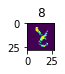

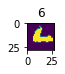

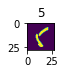

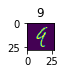

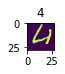

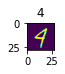

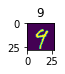

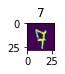

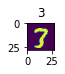

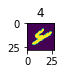

In [21]:
predictions_train = model.predict(X)
log.info(predictions_train.shape)

analyse_confusing_predictions(predictions_train, labels=y1)

In [19]:
assert False

AssertionError: 

In [ ]:
t = np.zeros
t = None
if t:
    print('a')

In [ ]:
t1 = np.arange(100, 1000, 100).reshape(3, 3)
t2 = np.array([(0, 1), (1, 2), (0, 2)])
print(t1)
print(t2)
t1[0][t2[0]]
# t1[:, {(0, 1), (1, 2), (0, 2)}]
# t1[:, t2]

In [ ]:
a = []
for i, row in enumerate(t1):
    print(row)
    print(i)
    print(row[t2[i]])
    a.extend((row[t2[i]]))
np.array(a).reshape(t2.shape)

In [ ]:
t3 = np.empty_like(t2)
for i, row in enumerate(t1):
    print(row)
    print(i)
    print(row[t2[i]])
    t3[i] = row[t2[i]]
t3

In [ ]:
csv_predictions(predictions_sparse, 'cnn_predictions.csv')

### 2.2 K-Fold

In [ ]:
import sklearn.metrics
sklearn.metrics.SCORERS.keys()

In [ ]:
sklearn.utils.multiclass.type_of_target()

In [ ]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

if args.run_kfold_cnn:
    keras_classifier = KerasClassifier(build_baseline_model, batch_size=64)
    gcv = GridSearchCV(keras_classifier,
                             param_grid={'epochs': [3, 4, 5, 10]},
                             cv=5,
                             scoring='neg_log_loss',
                             n_jobs=-1,
                             verbose=5)
    gcv.fit(X, y)

    log.info('Best params: %s', repr(gcv.best_params_))
    log.info('Best CV score: ' + repr(gcv.best_score_))        
    log.info('Best std:' + repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))
    # validator.best_estimator_ returns sklearn-wrapped version of best model.
    # validator.best_estimator_.model returns the (unwrapped) keras model
    best_model = gcv.best_estimator_.model
    predictions = best_model.predict(x)
    predictions = np.argmax(predictions, axis=1)
    csv_predictions(predictions, 'cnn_predictions_kfold.csv')

### 2.3 Choosing the best cnn architecture

In [ ]:
from keras import layers 
from keras import models

layers_candidates = {
    1: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')],
    
#     2: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(10, activation='softmax')],
    
#     3: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(10, activation='softmax')],
    
#     4: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(10, activation='softmax')],
    
}

def build_model(layers_candidates_key =1):
    model = models.Sequential(layers_candidates[layers_candidates_key])
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    log.info('Build model:')
    log.info(model.summary())
    return model

In [ ]:
from keras import layers 

keras_classifier = KerasClassifier(build_model, layers_candidates_key=1)
gcv = GridSearchCV(keras_classifier,
#                          param_grid={'epochs': [2, 3, 4, 5, 7, 10, 15], 'layers_candidates_key': list(layers_candidates.keys())},
                         param_grid={'epochs': [2], 'layers_candidates_key': list(layers_candidates.keys())},
                         cv=5,
                         scoring='accuracy',
                         n_jobs=-1,
                         verbose=5)
gcv.fit(X, y)
# keras_classifier.fit(X, y)
log.info('Best params: %s', repr(gcv.best_params_))
log.info('Best CV score: %s', repr(gcv.best_score_))
log.info('Best std: %s', repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))

In [ ]:
assert False

In [ ]:
args.X.shape
args.X.to_numpy().reshape(args.X.shape[0], 28, 28, 1)
pd.get_dummies(args.y, prefix='label').to_numpy()

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

def svm_classifier_builder(params_dict=None):
    _params_dict = params_dict if params_dict else {}
    return SVC(**_params_dict, kernel='linear')

parameters = {'C': [0.01], 'gamma': [0.001]}

if args.run_svm:
    best_params, score, predictions = predict(args.X, args.y, args.x, svm_classifier_builder, parameters)
    csv_predictions(predictions, 'svm_predictions.csv')

## 3. Model Evaluation

#### These numbers may vary from time to time 
| Approach | Model  | Test score  |
|---|---|---|
| Baseline | No validation, 200 epochs  | 0.99157, 0.98857 |
| Baseline | Validation (20%), 45 epochs  | 0.98885 |
| Baseline | Validation (20%), 200 epochs, early stopping val_loss  | 0.98628 |
| Baseline | Validation (20%), 200 epochs, early stopping val_accuracy  | 0.98957 |
| Baseline | Validation (10%), 200 epochs, early stopping val_loss  | 0.98700 |
| Baseline | Validation (10%), 200 epochs, early stopping val_accuracy  | 0.98857 |
| K-Fold | Scoring neg_log_loss, cv=5  | 0.98200 |
| K-Fold | Scoring neg_log_loss, cv=12  | 0.98142 |